# NK models of evolution

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py

%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate

from numpy.random import rand, randint, permutation

## The NK landscape

Here's an implementation of an NK landscape.

A location in the landscape is represented by a NumPy array of N 0s and 1s.

The `index` attribute of `NKLandscape` is an array of indices into a location, which is an efficient way to select the overlapping slices.

The `cache` attribute is a dictionary that maps from `(i, slice)` to a fitness, where `i` indicates which of the `N` functions we want to evaluate and `slice` is the parameters of the function.

The first time we see a particular `(i, slice)` pair, we generate a random fitness value.  The we store it in the `cache` in case we need it again.

In [2]:
class NKLandscape:
    def __init__(self, N, K, A=2):
        """Create a landscape.
        
        N: number of attributes
        K: number of interactions
        
        index is a NumPy array that specifies the interactions between
        attributes. (The K+1 entries in each row identify the attributes
        that contribute to the fitness of the row attribute.)
        """
        self.N = N
        self.K = K
        self.A = A
        self.cache = dict()
        
        # compute the powers of 2 up to K, used in lookup()
        self.powers = 2 ** np.arange(K, -1, -1)

        # compute the index, used in fitness()
        iseq = np.array(range(N))
        jseq = np.array(range(K+1))
        self.index = (iseq[:, None] + jseq[None, :]) % N

    def random_loc(self):
        """Choose a random location."""
        return randint(self.A, size=self.N, dtype=np.uint8)
    
    def lookup(self, i, row):
        """Look up `row` in function `i`.
        
        i: int from 0 to N-1
        row: array of K+1 0s and 1s
        
        returns: f_i(row)
        """  
        #key = i, np.sum(self.powers * row)
        key = i, tuple(row)
        return self.cache.setdefault(key, rand())
    
    def fitness(self, loc):
        """Evaluates the fitness of a location.
        
        loc: array of N 0s and 1s
        
        returns: float fitness
        """
        slices = loc[self.index]
        fs = [self.lookup(i, row) for i, row in enumerate(slices)]
        return np.mean(fs)

Here's a small example.  The index shows how the traits are linked.  Trait 0 is linked to traits 1 and 2.  Trait 1 is linked to traits 2 and 3, etc.

In [3]:
nkland = NKLandscape(5, 2)
nkland.index

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 0],
       [4, 0, 1]], dtype=int32)

Here's an example that evaluates the fitness at a random location:

In [4]:
loc = nkland.random_loc()
loc, nkland.fitness(loc)

(array([1, 1, 1, 1, 1], dtype=uint8), 0.42916196650816)

Here's what the landscape cache looks like after one evaluation:

In [5]:
nkland.cache

{(0, (1, 1, 1)): 0.302004723124896,
 (1, (1, 1, 1)): 0.10311941969784855,
 (2, (1, 1, 1)): 0.27081252611648077,
 (3, (1, 1, 1)): 0.8866123799972616,
 (4, (1, 1, 1)): 0.5832607836043132}

If we evaluate the same location again, we should get the same value.

In [6]:
loc, nkland.fitness(loc)

(array([1, 1, 1, 1, 1], dtype=uint8), 0.42916196650816)

And if we evaluate a different location, we should get a different value.

In [7]:
loc = nkland.random_loc()
loc, nkland.fitness(loc)

(array([1, 1, 0, 1, 0], dtype=uint8), 0.5579815727957368)

## The agents

Here's a parent class, `NKAgent`, that contains code used by all agents:

In [8]:
class NKAgent:
    """Represents an agent in an NK model."""
    
    def __init__(self, landscape):
        """Create an agent at the given location.
        
        loc: array of N 0s and 1s
        landscape: reference to an NKLandscape
        """
        self.landscape = landscape
        self.loc = landscape.random_loc()
        self.fitness = landscape.fitness(self.loc)
        self.moves = 0
        self.done = False
        
    def mutation(self, direction):
        """Computes the location in the given direction.
        
        Result differs from the current location along the given axis.
        
        direction: int index from 0 to N-1
        
        returns: new array of N 0s and 1s
        """
        new_loc = self.loc.copy()
        new_loc[direction] ^= 1
        return new_loc
    
    def generate_mutations(self):
        """Generates all possible mutations from current location, in random order.
        
        yields: new array of N 0s and 1s
        """
        for direction in permutation(self.landscape.N):
            new_loc = self.mutation(direction)
            yield new_loc

    def consider(self, new_loc):
        """Moves if the fitness at `new_loc` is greater than or equal to current fitness.
        
        new_loc: array of N 0s and 1s
        
        return: True if the agent moved
        """
        new_fitness = self.landscape.fitness(new_loc)
        if new_fitness >= self.fitness:
            self.loc = new_loc
            self.fitness = new_fitness
            self.moves += 1
            return True
        return False
    
    def step(self):
        """Child classes should override this method."""
        pass

Here's an example using the NKAgent parent class.

In [9]:
agent = NKAgent(nkland)
agent.loc, agent.fitness

(array([1, 0, 0, 0, 0], dtype=uint8), 0.7332312067753596)

We can choose a random direction.

In [10]:
direction = randint(nkland.N)
new_loc = agent.mutation(direction)
new_loc

array([1, 1, 0, 0, 0], dtype=uint8)

And consider moving.

In [11]:
agent.consider(new_loc)

False

In [12]:
agent.loc, agent.fitness

(array([1, 0, 0, 0, 0], dtype=uint8), 0.7332312067753596)

The following loop considers every direction, in random order, and accepts the first acceptable move.

In [13]:
for direction in permutation(nkland.N):
    new_loc = agent.mutation(direction)
    if agent.consider(new_loc):
        print(agent.loc, agent.fitness)

[0 0 0 0 0] 0.7821259876012903


Now we can encapsulate that strategy, called the "fitter" strategy, in a class:

In [14]:
class NKAgentFitter(NKAgent):
    def step(self):
        """Consider all mutations in order and choose the first improvement."""
        if self.done:
            return False
        
        for new_loc in self.generate_mutations():
            if self.consider(new_loc):
                return True
            
        self.done = True
        return False

In [15]:
agent = NKAgentFitter(nkland)
agent.loc, agent.fitness

(array([0, 0, 1, 1, 0], dtype=uint8), 0.4343705257008962)

In [16]:
agent.step()

True

In [17]:
agent.loc, agent.fitness

(array([0, 0, 0, 1, 0], dtype=uint8), 0.6346721980410921)

**Exercise:** Implement the other strategies described by Vidgen and Padget in [Sendero](http://jasss.soc.surrey.ac.uk/12/4/8.html).

Write a class definition called `NKAgentMutant` that implements the one-mutant neighbor strategy and a class definition called `NKAgentGreedy` that implements the greedy strategy.  Instantiate one of each and invoke their step methods.

In [18]:
# Solution goes here

class NKAgentMutant(NKAgent):

    def step(self):
        """Choose a mutation at random and consider it."""
        direction = randint(len(self.loc))
        new_loc = self.mutation(direction)
        return self.consider(new_loc)
            
class NKAgentGreedy(NKAgent):
    
    def step(self):
        """Consider all mutations and choose the best."""
        fits = [(self.landscape.fitness(new_loc), rand(), new_loc)
               for new_loc in self.generate_mutations()]
        fitness, _, new_loc = max(fits)
        return self.consider(new_loc)

## The simulator

Here's a class that runs simulations:

In [19]:
class NKSimulation:
    
    def __init__(self, landscape, num_agents, agent_maker):
        """Create the simulation:
        
        landscape: NKLandscape
        num_agents: int number of agents
        agent_maker: function that makes agents
        """
        self.landscape = landscape
        self.agents = [agent_maker(landscape) for _ in range(num_agents)]
        
    def step(self):
        """Run step on each agent.
        
        returns: list of boolean, whether each agent moves
        """
        return [agent.step() for agent in self.agents]
        
    def get_fitnesses(self):
        """Returns a list of agent fitnesses."""
        return [agent.fitness for agent in self.agents]
    
    def get_locations(self):
        """Returns a list of agent locations."""
        return [agent.loc for agent in self.agents]
    
    def get_peaks(self):
        """Returns the set of unique locations.
        
        If all agents have run until they reach a local peak,
        the result is a subset of the peaks.
        """
        locs = [tuple(loc) for loc in self.get_locations()]
        return set(locs)

    def get_peak_heights(self):
        """Returns the set of unique heights.
        
        If all agents have run until they reach a local peak,
        the result is heights of a subset of the peaks.
        """
        return set(self.get_fitnesses())
    
    def get_path_lengths(self):
        """Returns the number of moves for each agent.
        
        If all agents have run until they reach a local peak,
        the result is the sequence of path lengths.
        """
        return [agent.moves for agent in self.agents]

And here's an example with small values of `N` and `K`.  Initially the distribution of fitness is centered around 0.5.

0.5488122471762756

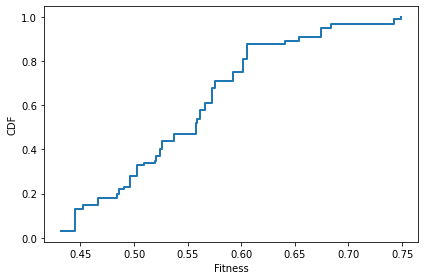

In [20]:
from empiricaldist import Cdf

nkl = NKLandscape(5, 2)
nksim = NKSimulation(nkl, 100, NKAgentFitter)
cdf_fitness = Cdf.from_seq(nksim.get_fitnesses())
cdf_fitness.step()
decorate(xlabel='Fitness', ylabel='CDF')

cdf_fitness.mean()

Here's how the distribution of fitness evolves after each step.

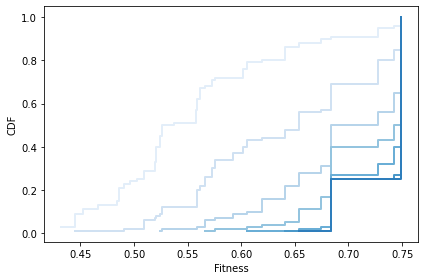

In [21]:
nksim = NKSimulation(nkl, 100, NKAgentFitter)
colors = sns.color_palette('Blues', 9)

for i in range(7):
    cdf_fitness = Cdf.from_seq(nksim.get_fitnesses())
    cdf_fitness.step(color=colors[i])
    nksim.step()
    
decorate(xlabel='Fitness', ylabel='CDF')

After every agent has found a peak, we can plot the distribution of fitness.

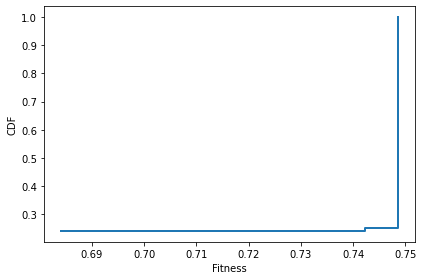

In [22]:
cdf_fitness = Cdf.from_seq(nksim.get_fitnesses())
cdf_fitness.step()
decorate(xlabel='Fitness', ylabel='CDF')

The number of unique locations is a lower bound on the number of peaks.

In [23]:
peaks = nksim.get_peaks()
len(peaks)

3

And we can look at the heights of the peaks.

In [24]:
heights = nksim.get_peak_heights()
heights

{0.6840880636229787, 0.7422685380087433, 0.7486469238760205}

Here's the distribution of path lengths.  A few agents are born on a peak.  The longest path is probably 5 or fewer.

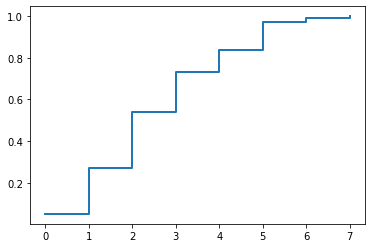

In [25]:
cdf_moves = Cdf.from_seq(nksim.get_path_lengths())
cdf_moves.step()

This function encapsulates the steps for running a simulation:

In [26]:
def run_simulation(N=5, K=2, num_agents=100, agent_maker=NKAgentFitter):
    """Create a simulation and run until all agents find a peak.
    
    N: int number of traits
    K: int number of interactions
    num_agents: int number of agents
    agent_maker: function that creates agents
    
    returns NKSimulation object
    """
    nkl = NKLandscape(N, K)
    nksim = NKSimulation(nkl, num_agents, agent_maker)
    for i in range(100):
        steps = nksim.step()
        if np.sum(steps) == 0:
            break
    return nksim

Here's the same small example:

In [27]:
nksim = run_simulation(N=5, K=2)

This function takes a completed simulation and summarizes the results.

In [28]:
def plot_results(nksim):
    """Summarizes simulation results.
    
    nksim: NKSimulation object
    """
    cdf_fitness = Cdf.from_seq(nksim.get_fitnesses())
    peaks = nksim.get_peaks()
    heights = nksim.get_peak_heights()
    cdf_moves = Cdf.from_seq(nksim.get_path_lengths())
    
    print("Mean fitness: ", cdf_fitness.mean())
    print("Mean path length: ", cdf_moves.mean())
    print("Number of peaks:", len(peaks))

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    cdf_fitness.step()
    decorate(xlabel='Fitness', ylabel='CDF')

    plt.subplot(1,2,2)
    cdf_moves.step()
    decorate(xlabel='Path Length', ylabel='CDF')

And here are the results with small values of `N` and `K`.

Mean fitness:  0.6803253677204664
Mean path length:  2.11
Number of peaks: 3


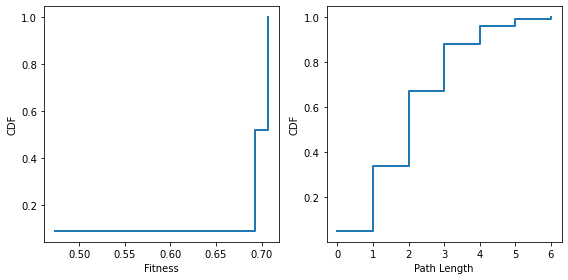

In [29]:
plot_results(nksim)

Here's a simulation run with larger `N` and `K`:

Wall time: 4.39 s
Mean fitness:  0.6470982377408329
Mean path length:  6.96
Number of peaks: 100


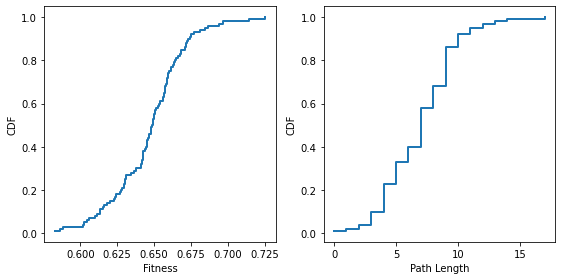

In [30]:
%time nksim = run_simulation(N=40, K=20)
plot_results(nksim)

**Exercise:** Starting with `N=5` and `K=3`, run simulations with increasing values of `N`, keeping `K` constant, and plot the number of peaks and mean path length as a function of `N`.

In [31]:
# Solution

K = 3
res = []

ns = range(5, 30)
for N in ns:
    nksim = run_simulation(N, K)
    num_peaks = len(nksim.get_peaks())
    mean_path = np.mean(nksim.get_path_lengths())
    res.append((num_peaks, mean_path))
    
peaks, paths = np.transpose(res)

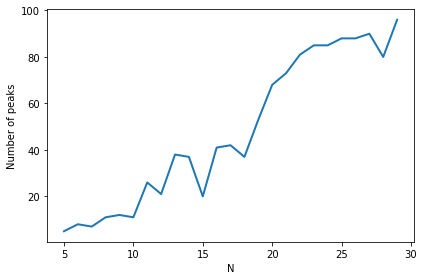

In [32]:
# Solution

plt.plot(ns, peaks)
decorate(xlabel='N', ylabel='Number of peaks')

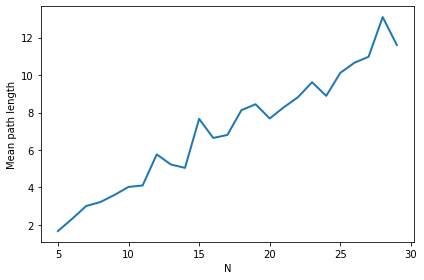

In [33]:
# Solution

plt.plot(ns, paths)
decorate(xlabel='N', ylabel='Mean path length')

**Exercise:** Starting with `N=20` and `K=0`, run simulations with increasing values of `K`, keeping `N` constant, and plot the number of peaks and mean path length as a function of `K`.

In [34]:
# Solution

N = 20
res = []

ks = range(0, 20)
for K in ks:
    nksim = run_simulation(N, K)
    num_peaks = len(nksim.get_peaks())
    mean_path = np.mean(nksim.get_path_lengths())
    res.append((num_peaks, mean_path))
    
peaks, paths = np.transpose(res)

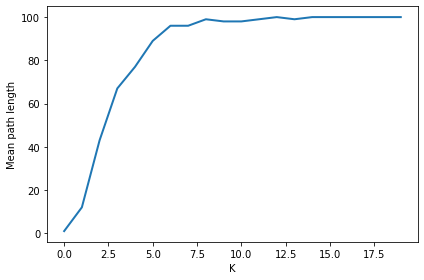

In [35]:
# Solution

plt.plot(ks, peaks)
decorate(xlabel='K', ylabel='Mean path length')

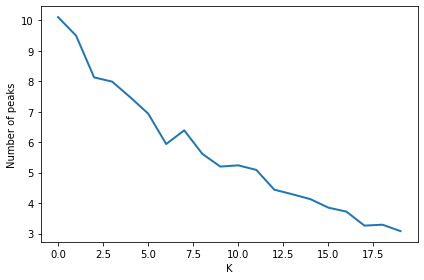

In [36]:
# Solution

plt.plot(ks, paths)
decorate(xlabel='K', ylabel='Number of peaks')

## Neutral networks

Consider the extension of the NK model proposed by Newman and Engelhardt (1998), in which fitness values are quantized rather than continuous. Below is a subclass of NKLandscape that implements this extension, which is sometimes called the NKq model.

In [37]:
class NKqLandscape(NKLandscape):
    def __init__(self, N, K, A=2, F=2):
        """Create a landscape with quantized fitness values.
        
        N: number of attributes
        K: number of interactions
        A: number of alleles per attribute
        F: number of quantized fitness values
        
        index is a NumPy array that specifies the interactions between
        attributes. (The K+1 entries in each row identify the attributes
        that contribute to the fitness of the row attribute.)
        """
        NKLandscape.__init__(self, N, K, A)
        self.F = F
    
    def lookup(self, i, row):
        """Look up `row` in function `i`.
        
        i: int from 0 to N-1
        row: array of K+1 0s and 1s
        
        returns: f_i(row)
        """
        key = i, tuple(row)
        return self.cache.setdefault(key, randint(self.F)/(self.F-1))

In [38]:
nkqland = NKqLandscape(5, 2, 2, 2)

In [39]:
loc = nkqland.random_loc()
loc, nkqland.fitness(loc)

(array([0, 1, 0, 0, 1], dtype=uint8), 0.4)

In [40]:
nkqland.cache

{(0, (0, 1, 0)): 0.0,
 (1, (1, 0, 0)): 1.0,
 (2, (0, 0, 1)): 0.0,
 (3, (0, 1, 0)): 0.0,
 (4, (1, 0, 1)): 1.0}

The NKq model gives rise to "neutral networks". A neutral network is "a set of sequences [locations] that all possess the same fitness and that are connected together via ... point mutations" (p. 1335). Newman and Engelhardt (hereafter NE) discover some striking properties of these networks, which, they suggest, greatly improve the performance of single-mutation evolutionary search on rugged fitness landscapes. In the exercises below, we ask you to replicate and interpret some of their results.

### Detecting and analyzing neutral networks

To get you started, here's a class that might help.  It keeps track of a collection of nodes that are at the same fitness level.  It figures out which nodes are one-bit neighbors and creates edges between them.  Then it uses NetworkX to find all connected components.

The tricky part of this implementation is that it converts each location from an array of 0s and 1s to an integer; it uses these integers as nodes in the graph, and it uses bitwise operations on these integers to check for neighbor relationships.

In [41]:
import networkx as nx

class GraphOfLoc:
    """Represents a graph of locations."""
    
    def __init__(self, N):
        self.g = nx.Graph()
        
        # precompute the powers of 2, used in add()
        self.powers = 2 ** np.arange(N-1, -1, -1)
        
    def add(self, new_loc):
        """Adds a location to a graph.
        
        new_loc: location in the form of an int
        """
        locint = np.sum(self.powers * new_loc)
        self.g.add_node(locint)

        if len(self.g):
            # put the other locs into an array
            other_locs = np.array(list(self.g.nodes()))
            
            # compute the indices of the neighbors
            index = np.in1d(locint ^ other_locs, self.powers)
            neighbors = other_locs[index]
            
            # add edges from the new loc to all neighbors
            self.g.add_edges_from([(locint, n) for n in neighbors])
        
    def components(self):
        """Connected components of the graph.
        
        returns: iterator of sets of nodes.
        """
        return nx.algorithms.connected_components(self.g)
    
    def component_sizes(self):
        return [len(component) for component in self.components()]
        
    def __str__(self):
        return str(self.g)

Here's a small example that shows how it works.

In [42]:
graph = GraphOfLoc(5)
graph.add([0,0,0,0,0])
graph.g.nodes(), graph.g.edges()

(NodeView((0,)), EdgeView([]))

When we add another node that is a neighbor of the first, we get an edge between them.

In [43]:
graph.add([0,0,0,0,1])
graph.g.nodes(), graph.g.edges()

(NodeView((0, 1)), EdgeView([(0, 1)]))

Here's another node that is also a neighbor of the first (but not of the second).

In [44]:
graph.add([0,0,0,1,0])
graph.g.nodes(), graph.g.edges()

(NodeView((0, 1, 2)), EdgeView([(0, 1), (0, 2)]))

And here's a node that's not connected.

In [45]:
graph.add([1,1,0,0,0])
graph.g.nodes(), graph.g.edges()

(NodeView((0, 1, 2, 24)), EdgeView([(0, 1), (0, 2)]))

If we print the sizes of the connected components, we get one set of 3 nodes and 1 unconnected node.

In [46]:
for component in graph.components():
    print(len(component))

3
1


Now let's find all connected components for all fitness levels in a quantized landscape.

In [47]:
N = 10
K = 4
nkqland = NKqLandscape(N, K)

`make_locs` makes an array that contains the binary representation of all locations in a landscape.

In [48]:
def make_locs(N):
    """Makes an array of binary numbers from 0..2**N-1.
    
    returns: array of 1s and 0s with 2**N rows and N cols
    """
    # array of numbers
    locints = np.arange(2**N, dtype=np.uint64)
    
    # array of 1s and 0s
    locs = np.zeros((N, len(locints)), dtype=np.uint8)
    
    # fill in the rows
    for i in range(N):
        locs[i] = locints % 2
        locints >>= 1
    
    # flip and transpose
    return np.flipud(locs).transpose()

For `N=10`, there are `2**N = 1024` locations.

In [49]:
locs = make_locs(N)
len(locs)

1024

`collect_graph` enumerates the locations in the landscape, computes the fitness of each, and makes a dictionary that maps from each fitness level to a `GraphOfLoc` that contains the locations at that fitness level.

In [50]:
from collections import defaultdict

def collect_graphs(nkqland):
    locs = make_locs(nkqland.N)
    d = defaultdict(lambda: GraphOfLoc(nkqland.N))

    for loc in locs:
        fitness = nkqland.fitness(loc)
        d[fitness].add(loc)
        
    return d

In [51]:
%time d = collect_graphs(nkqland)

Wall time: 453 ms


We can summarize the results by printing the fitness levels and the sizes of the connected components at each level.

In [52]:
def summarize_graphs(d):
    for fitness, graph in sorted(d.items()):
        sizes = graph.component_sizes()
        sizes.sort(reverse=True)
        print(fitness, sizes)

In [53]:
summarize_graphs(d)

0.0 [1]
0.1 [2, 2, 2, 1]
0.2 [6, 5, 5, 3, 3, 2, 2, 1, 1, 1]
0.3 [27, 14, 7, 6, 4, 4, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.4 [168, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.5 [225, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.6 [204, 4, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.7 [101, 20, 6, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]
0.8 [14, 8, 6, 6, 4, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1]
0.9 [5, 4, 2, 2, 2, 1, 1, 1, 1, 1, 1]
1.0 [1]


Here is a function that extracts the sizes of the components. (Recall that in the language of the NE paper, each component in this graph is a neutral network.)

In [54]:
def all_component_sizes(d):
    """Extract the sizes of the components.
    
    returns: list of int
    """
    t = []
    for fitness, graph in d.items():
        t.extend(graph.component_sizes())
    return t

And here is a function that computes the fraction of locations (or sequences, in NE's terminology) that reside in "common" networks, where a common network is one that is larger than average.

In [55]:
def prob_common(sizes):
    """Computes the fraction of sequences in common neutral networks.
    
    sizes: list of component sizes
    """
    mean = np.mean(sizes)
    total = np.sum(sizes)
    common = np.sum([size for size in sizes if size>mean])
    return common / total

Finally, here is a function that runs a neutral network experiment. It takes values for `N`, `K`, and `F` (leaving the default value of `A`=2), creates an appropriate NKq landscape, instantiates a bunch of agents (by default, 100 agents that use the "fitter" strategy), and lets them walk the landscape.

The `run_experiment` function returns three things: a Cdf of neutral network sizes, the fraction of locations that reside in common networks, and the maximum fitness achieved by the agents. You may find these things remarkably useful in the exercises below.

In [56]:
def run_experiment(N, K, F=2, num_agents=100, agent_maker=NKAgentFitter):
    """Runs an experiment with the given parameters and return summaries.
    
    N: number of attributes
    K: number of interactions
    F: number of weights
    num_agents: int number of agents
    agent_maker: function that makes agents
    
    returns: Cdf of component (neutral network) sizes,
             float fraction of locations in a common network,
             float maximum fitness acheived by the agents
    """
    nkqland = NKqLandscape(N, K, F=F)
    
    d = collect_graphs(nkqland)
    sizes = all_component_sizes(d)
    cdf = Cdf.from_seq(sizes)
    pc = prob_common(sizes)
    
    nksim = NKSimulation(nkqland, num_agents, agent_maker)
    for i in range(100):
        steps = nksim.step()
        if np.sum(steps) == 0:
            break

    max_fit = np.max(nksim.get_fitnesses())
    
    return cdf, pc, max_fit

### Your turn!

**Exercise:** Run experiments for a single value of `N` (e.g., 14) and several values of `K` (e.g., 1, 2 and 5). Plot the distribution of neutral network sizes. Compare your results with Figure 1 in the NE paper.

1
2
5


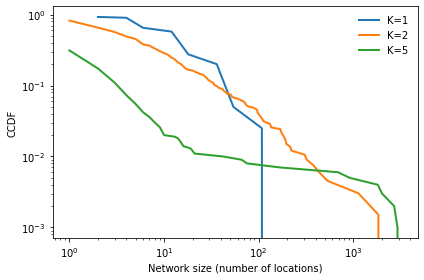

In [57]:
# Solution

N = 14
ks = [1, 2, 5]
for K in ks:
    print(K)
    cdf, _, _ = run_experiment(N, K)
    (1-cdf).plot(label='K=%d' % K)
        
decorate(xlabel='Network size (number of locations)',
         ylabel='CCDF',
         xscale='log',
         yscale='log')

**Exercise:** Run experiments for a range of `N` values (e.g., 8 to 16) and several values of `K` (e.g., 2, 4 and 6). For each value of `K`, plot the fraction of locations that reside in common neutral networks. Compare your results with Figure 2 in the NE paper.

8 2 0.71484375
9 2 0.857421875
10 2 0.7470703125
11 2 0.84228515625
12 2 0.739501953125
13 2 0.72802734375
14 2 0.80029296875
15 2 0.8497314453125
8 4 0.73828125
9 4 0.71484375
10 4 0.8623046875
11 4 0.8232421875
12 4 0.859130859375
13 4 0.90771484375
14 4 0.93359375
15 4 0.9063720703125
8 6 0.71484375
9 6 0.734375
10 6 0.802734375
11 6 0.8330078125
12 6 0.859130859375
13 6 0.883056640625
14 6 0.90753173828125
15 6 0.916656494140625


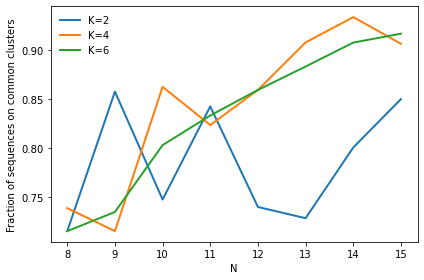

In [58]:
# Solution

for K in [2, 4, 6]:
    res = []
    for N in range(8, 16):
        _, pc, _ = run_experiment(N, K)
        print(N, K, pc)
        res.append((N, pc))
    ns, pcs = np.transpose(res)
    plt.plot(ns, pcs, label='K=%d' % K)
        
decorate(xlabel='N', ylabel='Fraction of sequences on common clusters')

**Exercise:** Run experiments for a single pair of `N` and `K` values (e.g., 14 and 4) and a range of `F` values (e.g., 2 to 16). Plot the maximum fitness achieved as a function of `F`. Compare your results with Figure 3 in the NE paper.

2 0.9285714285714286
3 0.8928571428571429
4 0.7857142857142857
5 0.8571428571428571
6 0.8
7 0.7976190476190476
8 0.8367346938775511
9 0.8482142857142857
10 0.7936507936507937
11 0.7785714285714286
12 0.766233766233766
13 0.8273809523809523
14 0.8241758241758241
15 0.8571428571428573
16 0.8238095238095238


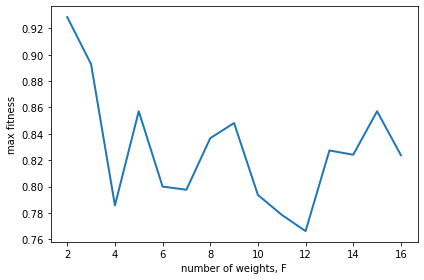

In [59]:
# Solution

N = 14
K = 4

res = []
for F in range(2, 17):
    cdf, pc, max_fit= run_experiment(N, K, F)
    print(F, max_fit)
    res.append((F, max_fit))
    
fs, max_fits = np.transpose(res)
plt.plot(fs, max_fits)
decorate(xlabel='number of weights, F', ylabel='max fitness')

**Exercise:** Putting these findings together, explain in your own words how neutrality helps an evolving population reach a higher level of fitness. How might you be able to harness this phenomenon in designing engineered artifacts and systems?

In [60]:
# Solution goes here